### Todos:
### 1. preprocess the data to make it suitable for glove embeding:
### a. remove ' from words( don't -> dont)
### b. convert all letters to lowercase ( Hoping -> hoping)
### 2. find the frequency of each emoji to see if the dataset is balanced and balance the dataset(important)

In [1]:
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
import numpy as np
import matplotlib.pyplot as plt
import interesting_labels

In [2]:
import pandas

In [3]:
def get_data():
    header = ['tweet','label']
    data_set = pandas.read_csv('augmented_data_new.txt',delimiter='\t',names = header)
    return data_set

# def get_label_mapping():
#     original_list = interesting_labels.wanted_list
#     output_list = [i for i in range(len(original_list))]
#     return dict(zip(original_list,output_list))
  
def split_tweet(tweet):
    return tweet.split()    


In [4]:
data_set = get_data()

In [5]:
glove = torchtext.vocab.GloVe(name="twitter.27B",dim=50)

In [6]:
len(data_set)

41388

In [7]:
type(data_set['tweet'][0])

str

In [8]:
def get_tweet_words(glove_vector):
    train, valid, test = [],[],[]
    for i in range(len(data_set)):
        tweet = data_set['tweet'][i]
        if(type(tweet) != str):
            continue
        idxs = [glove_vector.stoi[w]        # lookup the index of word
                for w in split_tweet(tweet)
                if w in glove_vector.stoi] # keep words that has an embedding
        if not idxs: # ignore tweets without any word with an embedding
            continue
        idxs = torch.tensor(idxs) # convert list to pytorch tensor
        label = torch.tensor(data_set['label'][i]).long()
        if i % 5 < 3:
            train.append((idxs, label))
        elif i % 5 == 4:
            valid.append((idxs, label))
        else:
            test.append((idxs, label))
    return train, valid, test

In [9]:
train, valid, test = get_tweet_words(glove)

In [10]:
num_classes = len(set([element[1].item() for element in train]))
num_classes

6

In [11]:
train[0]

(tensor([3653,   10,  348, 6456,   85,   53, 2706]), tensor(0))

In [12]:
valid[0]

(tensor([  10,  292,   15,   16,    4,   15,   55, 1271,  110]), tensor(2))

In [13]:
len(train)

24707

### Recurrent Neural Network Module

In [14]:
rnn_layer = nn.RNN(input_size=50,    # dimension of the input repr
                   hidden_size=50,   # dimension of the hidden units
                   batch_first=True) # input format is [batch_size, seq_len, repr_dim]

In [15]:
#tweet_input = tweet_emb.unsqueeze(0) # add the batch_size dimension
#h0 = torch.zeros(1, 1, 50)     # initial hidden layer
#out, last_hidden = rnn_layer(tweet_input, h0)

In [16]:
#print(out.shape)
#print(last_hidden.shape)

In [17]:
#out[:,-1,:]

### Building the model

In [18]:
class TweetRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TweetRNN, self).__init__()
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb(x)
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

model = TweetRNN(input_size=50, hidden_size=50, num_classes=num_classes)

In [19]:
data_set.nunique()

tweet    35252
label        6
dtype: int64

In [20]:
import random

class TweetBatcher:
    def __init__(self, tweets, batch_size=32, drop_last=False):
        # store tweets by length
        self.tweets_by_length = {}
        for words, label in tweets:
            # compute the length of the tweet
            wlen = words.shape[0]
            # put the tweet in the correct key inside self.tweet_by_length
            if wlen not in self.tweets_by_length:
                self.tweets_by_length[wlen] = []
            self.tweets_by_length[wlen].append((words, label),)
         
        #  create a DataLoader for each set of tweets of the same length
        self.loaders = {wlen : torch.utils.data.DataLoader(
                                    tweets,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    drop_last=drop_last) # omit last batch if smaller than batch_size
            for wlen, tweets in self.tweets_by_length.items()}
        
    def __iter__(self): # called by Python to create an iterator
        # make an iterator for every tweet length
        iters = [iter(loader) for loader in self.loaders.values()]
        while iters:
            # pick an iterator (a length)
            im = random.choice(iters)
            try:
                yield next(im)
            except StopIteration:
                # no more elements in the iterator, remove it
                iters.remove(im)

In [21]:
def get_accuracy(model, data_loader):
    correct, total = 0, 0
    for tweets, labels in data_loader:
        output = model(tweets)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return float(correct) / float(total)

test_loader = TweetBatcher(test, batch_size=32, drop_last=False)
get_accuracy(model, test_loader)


0.19620945207143725

In [22]:
for i in range(10):
    model = TweetRNN(input_size=50, hidden_size=50, num_classes=num_classes)
    test_loader = TweetBatcher(test, batch_size=32, drop_last=False)
    print(get_accuracy(model, test_loader))

0.2636374681083708
0.045073502612076294
0.08176406268983112
0.17178957599319644
0.13825780585591058
0.07265216863078605
0.20447090268497145
0.04847527639411979
0.23751670513910825
0.30555218077997814


In [23]:
def train_rnn_network(model, train, valid, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    epochs = []
    for epoch in range(num_epochs):
        for tweets, labels in train:
            optimizer.zero_grad()
            pred = model(tweets)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        losses.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train_loader))
        valid_acc.append(get_accuracy(model, valid_loader))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, loss, train_acc[-1], valid_acc[-1]))
        
    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

Epoch 1; Loss 1.284816; Train Acc 0.592145; Val Acc 0.590108
Epoch 2; Loss 0.965862; Train Acc 0.593412; Val Acc 0.591809
Epoch 3; Loss 1.098633; Train Acc 0.599324; Val Acc 0.599465
Epoch 4; Loss 1.148980; Train Acc 0.604941; Val Acc 0.604569
Epoch 5; Loss 1.152635; Train Acc 0.605236; Val Acc 0.601288
Epoch 6; Loss 0.818549; Train Acc 0.606208; Val Acc 0.604812
Epoch 7; Loss 1.177812; Train Acc 0.604688; Val Acc 0.601410
Epoch 8; Loss 1.130510; Train Acc 0.608108; Val Acc 0.604691
Epoch 9; Loss 1.274886; Train Acc 0.611275; Val Acc 0.607850
Epoch 10; Loss 1.076777; Train Acc 0.610684; Val Acc 0.603232
Epoch 11; Loss 0.975587; Train Acc 0.610304; Val Acc 0.606878
Epoch 12; Loss 0.975748; Train Acc 0.604096; Val Acc 0.597764
Epoch 13; Loss 1.152447; Train Acc 0.610135; Val Acc 0.602382
Epoch 14; Loss 1.138998; Train Acc 0.616892; Val Acc 0.609066
Epoch 15; Loss 1.038697; Train Acc 0.611233; Val Acc 0.603354
Epoch 16; Loss 1.301670; Train Acc 0.619341; Val Acc 0.607486
Epoch 17; Loss 0.

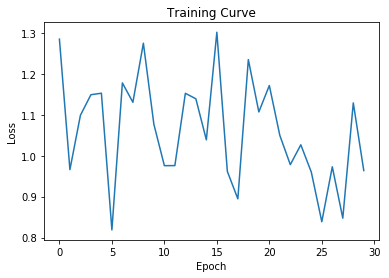

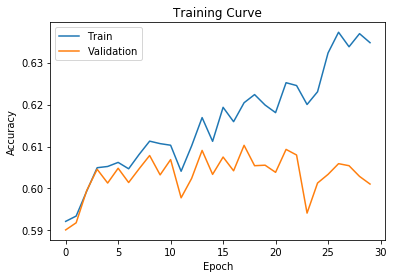

0.6011420240554003

In [26]:
model = TweetRNN(input_size=50, hidden_size=100, num_classes=num_classes)
train_loader = TweetBatcher(train, batch_size=64, drop_last=True)
valid_loader = TweetBatcher(valid, batch_size=64, drop_last=False)
train_rnn_network(model, train_loader, valid_loader, num_epochs=30, learning_rate=5e-4)
get_accuracy(model, test_loader)

Epoch 1; Loss 1.157079; Train Acc 0.584206; Val Acc 0.581723
Epoch 2; Loss 1.149996; Train Acc 0.596706; Val Acc 0.594847
Epoch 3; Loss 1.153192; Train Acc 0.594721; Val Acc 0.590594
Epoch 4; Loss 0.795207; Train Acc 0.601605; Val Acc 0.599830
Epoch 5; Loss 0.963572; Train Acc 0.600633; Val Acc 0.599951
Epoch 6; Loss 0.790925; Train Acc 0.606968; Val Acc 0.602625
Epoch 7; Loss 1.032325; Train Acc 0.599493; Val Acc 0.597642
Epoch 8; Loss 1.051568; Train Acc 0.607052; Val Acc 0.603111
Epoch 9; Loss 1.060650; Train Acc 0.602407; Val Acc 0.601288
Epoch 10; Loss 1.069642; Train Acc 0.606250; Val Acc 0.601653
Epoch 11; Loss 1.005716; Train Acc 0.610895; Val Acc 0.604326
Epoch 12; Loss 1.194171; Train Acc 0.604603; Val Acc 0.601531
Epoch 13; Loss 1.059918; Train Acc 0.604350; Val Acc 0.599951
Epoch 14; Loss 1.023660; Train Acc 0.609122; Val Acc 0.602503
Epoch 15; Loss 1.206127; Train Acc 0.608404; Val Acc 0.597886
Epoch 16; Loss 0.972213; Train Acc 0.612120; Val Acc 0.603962
Epoch 17; Loss 1.

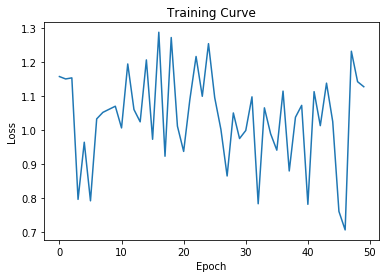

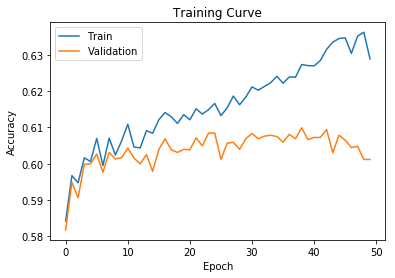

0.6001700886891022

In [27]:
model = TweetRNN(input_size=50, hidden_size=100, num_classes=num_classes)
train_loader = TweetBatcher(train, batch_size=64, drop_last=True)
valid_loader = TweetBatcher(valid, batch_size=64, drop_last=False)
train_rnn_network(model, train_loader, valid_loader, num_epochs=50, learning_rate=3e-4)
get_accuracy(model, test_loader)

### LSTM Model

In [28]:
class TweetLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TweetLSTM, self).__init__()
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb(x)
        # Set an initial hidden state and cell state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        c0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the LSTM
        out, _ = self.rnn(x, (h0, c0))
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

Epoch 1; Loss 0.810902; Train Acc 0.639358; Val Acc 0.603719
Epoch 2; Loss 1.037219; Train Acc 0.642483; Val Acc 0.604205
Epoch 3; Loss 0.878828; Train Acc 0.645988; Val Acc 0.602868
Epoch 4; Loss 0.905649; Train Acc 0.643243; Val Acc 0.603597
Epoch 5; Loss 0.977658; Train Acc 0.646115; Val Acc 0.598372
Epoch 6; Loss 1.182170; Train Acc 0.645608; Val Acc 0.596549
Epoch 7; Loss 0.781712; Train Acc 0.646791; Val Acc 0.603840
Epoch 8; Loss 1.085869; Train Acc 0.646917; Val Acc 0.601410
Epoch 9; Loss 0.663709; Train Acc 0.648564; Val Acc 0.601653
Epoch 10; Loss 0.999559; Train Acc 0.649620; Val Acc 0.598250
Epoch 11; Loss 1.015502; Train Acc 0.649029; Val Acc 0.603111
Epoch 12; Loss 0.945749; Train Acc 0.653801; Val Acc 0.601531
Epoch 13; Loss 0.856451; Train Acc 0.653463; Val Acc 0.599951
Epoch 14; Loss 0.962869; Train Acc 0.655490; Val Acc 0.598129
Epoch 15; Loss 0.946767; Train Acc 0.653758; Val Acc 0.594604
Epoch 16; Loss 1.100888; Train Acc 0.656377; Val Acc 0.597035
Epoch 17; Loss 0.

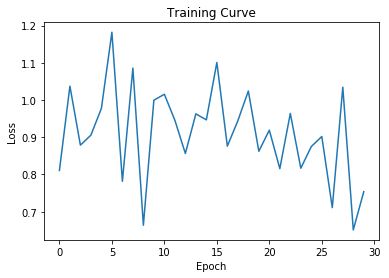

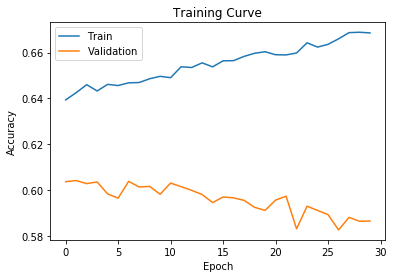

0.5834042036204592

In [29]:
model_lstm = TweetLSTM(input_size=50, hidden_size=50, num_classes=num_classes)
train_rnn_network(model, train_loader, valid_loader, num_epochs=30, learning_rate=2e-4)
get_accuracy(model, test_loader)

Epoch 1; Loss 0.683762; Train Acc 0.669215; Val Acc 0.573095
Epoch 2; Loss 1.110208; Train Acc 0.670735; Val Acc 0.576862
Epoch 3; Loss 0.912757; Train Acc 0.668792; Val Acc 0.578199
Epoch 4; Loss 0.639515; Train Acc 0.676858; Val Acc 0.574918
Epoch 5; Loss 0.956683; Train Acc 0.673775; Val Acc 0.580629
Epoch 6; Loss 0.825882; Train Acc 0.680532; Val Acc 0.573581
Epoch 7; Loss 0.902239; Train Acc 0.672297; Val Acc 0.583668
Epoch 8; Loss 0.867204; Train Acc 0.670524; Val Acc 0.585004
Epoch 9; Loss 0.917163; Train Acc 0.685473; Val Acc 0.576255
Epoch 10; Loss 0.922079; Train Acc 0.684628; Val Acc 0.578564
Epoch 11; Loss 0.791709; Train Acc 0.689569; Val Acc 0.558756
Epoch 12; Loss 0.805403; Train Acc 0.693454; Val Acc 0.574918
Epoch 13; Loss 0.865206; Train Acc 0.697846; Val Acc 0.569328
Epoch 14; Loss 0.956021; Train Acc 0.695566; Val Acc 0.564589
Epoch 15; Loss 0.888766; Train Acc 0.689189; Val Acc 0.573824
Epoch 16; Loss 0.863191; Train Acc 0.701943; Val Acc 0.565925
Epoch 17; Loss 0.

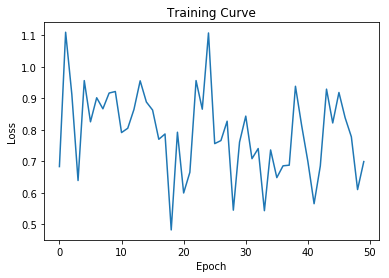

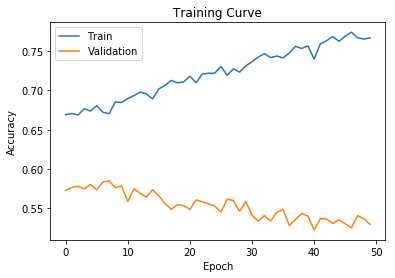

0.5293402988701251

In [30]:
model_lstm = TweetLSTM(input_size=50, hidden_size=50, num_classes=num_classes)
train_rnn_network(model, train_loader, valid_loader, num_epochs=50, learning_rate=5e-4)
get_accuracy(model, test_loader)